In [1]:
import gym
import math
import random
import time
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

env = gym.make('LunarLander-v2')
# env = gym.make("LunarLander-v2", render_mode="human")

# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Replay Memory


In [2]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, tup):
        """Save a transition"""
        self.memory.append(tup)

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [3]:
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [4]:
class Trainer:
    def __init__(self, model, learning_rate) -> None:
        self.model : DQN = model.to(device)
    
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        self.loss_fn = nn.MSELoss()
        

    def predict(self, state, no_grad=False):
        state = torch.tensor(state).to(device)
        
        if no_grad:
            with torch.no_grad():
                return self.model(state)
        else:
            return self.model(state)
    
    def train(self,y, y_):

        
       
        # print("---*----")
        # print(y.shape, y_.shape)
        
        # print(y[0:2])
        # print(y_[0:2])
        # print("---*----")
        # training step & backprop
        self.optimizer.zero_grad()    
        self.loss = self.loss_fn(y, y_).float()
        self.loss.backward()
        self.optimizer.step()
        
        return self.loss.item()



In [5]:
class Agent:
    def __init__(self, 
                 env:gym.Env, 
                 memory, 
                 trainer,
                 epsilon=50.,
                 BATCH_SIZE=128,
                 GAMMA=0.99) -> None:
        
        self.env = env
        self.memory : ReplayMemory = memory
        self.trainer: Trainer = trainer

        # parameters 
        self.epsilon = epsilon
        self.BATCH_SIZE = BATCH_SIZE
        self.GAMMA = GAMMA

        self.history = {}
        
    
    def replay(self):
        # st = time.time()
        if len(self.memory)>=self.BATCH_SIZE:
            samples = self.memory.sample(self.BATCH_SIZE) # state, action,reward, new_state, terminated 
            
            
            # batch of states and new states
            batch_state = [sample[0] for sample in samples]
            batch_new_state = [sample[3] for sample in samples]
          
            batch_state = torch.tensor(batch_state)
            batch_new_state = torch.tensor(batch_new_state)

            y = self.trainer.predict(batch_state.to(device)) # y : predicted q values
            q_values = [] # q_values :  list for estimated target q value
            # batch prediction for next state (to improve train speed)
            q_values_next = self.trainer.predict(batch_new_state.to(device))
            
            # target q value estimation
            for  i, sample in enumerate(samples):
                _, action,reward, _, terminated = sample
                q_value = y[i].clone()
                
                if terminated:
                    q_value[action] = reward
                else:
                    q_value[action] = reward + self.GAMMA*q_values_next[i].max()

                q_values.append(q_value)  
                
        else: 
            return
        
        q_values = torch.stack(q_values).to(device)

        loss = self.trainer.train(y, q_values) # predicted values & estimated target q values

        return loss

    def get_exploration_rate(self, episode, epsilon):
     
        """
        Get the exploration_rate given an episode subject to decay (epsilone)

        inputs:
        -------
            e: a given episode
        return:
        -------
            a learning or an exploration rate
         """
        return max(0.1, min(1., 1. - np.log10((episode + 1) / epsilon)))
    
    def get_action(self, state, exploration_rate):
        # print(exploration_rate)
        if (np.random.random() < exploration_rate):
            return self.env.action_space.sample()
        else:
        # Choose greedily the action which gives the highest expected reward
        # given the current state
            return torch.argmax(self.trainer.predict(state)).item()

    def train(self, EPISODES):
    
        LOSS = []
        episode_rewards = []
        for e in range(1, EPISODES+1):
            state, _ = env.reset()
            terminated = False
            total_reward = 0
            
            frame = 0
            while not terminated:
                rate = self.get_exploration_rate(episode=e, epsilon=self.epsilon)
                action = self.get_action(state, rate)
                new_state, reward, terminated, _, _ = env.step(action)
                
                self.memory.push((state, action,reward,new_state, terminated))   
                total_reward +=reward
                # update old state for new step
                state = new_state

                loss = self.replay() # replay memory to train DQN model
                frame += 1
                # episode end if it takes too many steps
                if frame>250:
                    terminated = True
                    
            print(f" EPISODE {e}|{EPISODES} reward {total_reward} | loss: {loss}", end="\r")
            # print(f" EPISODE {e}|{EPISODES} reward {total_reward} | replay time {replay_end-replay_start:.3f}")
                
            if loss != None:
                LOSS.append(loss)
                episode_rewards.append(total_reward)
                
            if e%100==0:
                print(f"EPISODE {e}|{EPISODES} {total_reward} | Loss {loss}") 
        
        self.history["loss"] = LOSS
        self.history["rewards"] = episode_rewards
        return self.history
        
    def play(self):
        state, _ = env.reset()
        terminated = False
        total_reward = 0
        frame = 0
        while not terminated:
            # action = self.get_action(state, exploration_rate=-1)
            action = torch.argmax(self.trainer.predict(state, no_grad=True)).item()
            state, reward, terminated, _, _ = env.step(action)
            total_reward +=reward
            frame += 1
        print("REWARD", total_reward, "FRAMES", frame)


In [6]:
trainer = Trainer(model=DQN(n_actions=env.action_space.n,n_observations=env.observation_space.shape[0]),
                  learning_rate=0.001)

In [7]:
cart_pole_agent = Agent(env=env,
                        trainer=trainer,
                        memory=ReplayMemory(1000),
                        epsilon=25.)

In [8]:
history = cart_pole_agent.train(130)

c:\Users\pritom52251.WHILDC\AppData\Local\miniconda3\envs\RLml\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
C:\Users\pritom52251.WHILDC\AppData\Local\Temp\ipykernel_15788\3346664287.py:32: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:264.)
  batch_state = torch.tensor(batch_state)
C:\Users\pritom52251.WHILDC\AppData\Local\Temp\ipykernel_15788\1509033004.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state).to(device)


EPISODE 100|130 -66.73486493364022 | Loss 0.17987611889839172889839172


In [23]:
env.close()
env = gym.make("LunarLander-v2", render_mode="human")
# env = gym.make("LunarLander-v2")
cart_pole_agent.env = env

In [24]:
for i in range(10):
    cart_pole_agent.play()

REWARD 29.349295435012607 FRAMES 100
REWARD -12.582932067918051 FRAMES 122
REWARD 49.81772237007101 FRAMES 120
REWARD 3.2402219360657654 FRAMES 109
REWARD -13.288835659960824 FRAMES 133
REWARD -80.59967248454534 FRAMES 100
REWARD 226.7210926702901 FRAMES 159
REWARD 157.69520435669602 FRAMES 3990
REWARD 23.424917068568632 FRAMES 111
REWARD -229.5163795686246 FRAMES 112


In [11]:
env.close()

In [12]:
# break

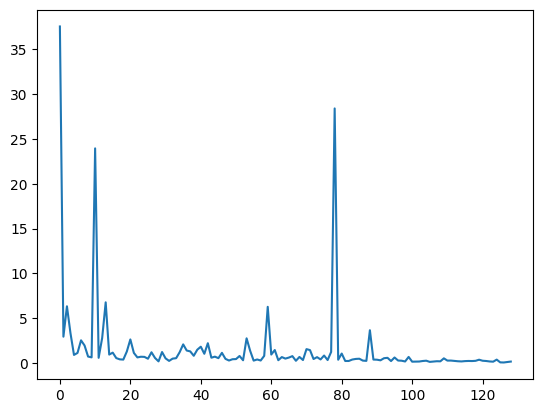

In [13]:
# plt.figure(figsize=(16,16))
plt.plot(history["loss"])
# plt.axes()

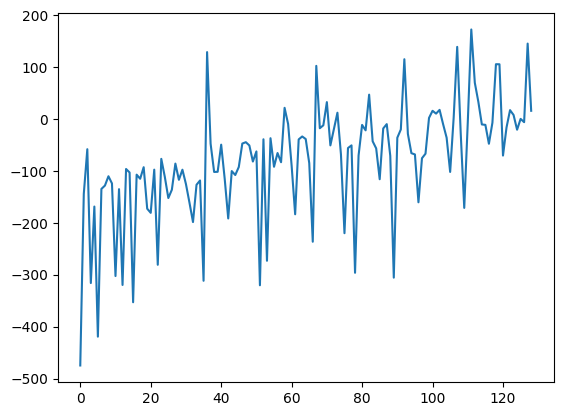

In [14]:
plt.plot(history["rewards"])

In [15]:
# import seaborn as sns

In [16]:
# Tensor_a = trainer.model.layer1.weight.clone()
# Tensor_b = trainer.model.layer2.weight.clone()

In [17]:
# plt.figure(figsize=(12,10))
# sns.heatmap(Tensor_a.detach().numpy(), linewidth=0.5)

In [18]:
# plt.figure(figsize=(12,10))
# sns.heatmap(Tensor_b.detach().numpy(), linewidth=0.5)

In [25]:
!pip list

Package                       Version
----------------------------- ---------
arrow                         1.2.3
asttokens                     2.2.1
async-lru                     2.0.4
Babel                         2.12.1
backcall                      0.2.0
backports.functools-lru-cache 1.6.5
box2d-py                      2.3.8
brotlipy                      0.7.0
certifi                       2023.7.22
cffi                          1.15.1
charset-normalizer            2.0.4
cloudpickle                   2.2.1
colorama                      0.4.6
comm                          0.1.4
contourpy                     1.1.0
cryptography                  41.0.3
cycler                        0.11.0
debugpy                       1.6.8
decorator                     5.1.1
exceptiongroup                1.0.4
executing                     1.2.0
filelock                      3.9.0
fonttools                     4.42.1
fqdn                          1.5.1
gym                           0.26.1
gym-notices 